<a href="https://colab.research.google.com/github/sfansaria/GMM_ExpectationAndMaximizationMethod/blob/main/Copy_of_EM_METHOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install gpytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 13.0 MB/s eta 0:00:00


In [ ]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans

In [ ]:
iris = datasets.load_iris()
X = iris.data
X[:20]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3]])

In [ ]:
X.shape

(150, 4)

In [ ]:
def gaussian(X, mu, cov):
  n = X.shape[1]
  diff = (X-mu).T
  return np.diagonal(1/((2*np.pi)**(n/2) *np.linalg.det(cov)**0.5)*np.exp(-0.5*np.dot(np.dot(diff.T,np.linalg.inv(cov)),diff)))

In [ ]:
x0 = np.array([[0.05, 1.413, 0.212],[0.85, -0.3, 1.11],[11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
m =np.mean(x0, axis=0)
c = np.dot((x0-m).T, x0-m)/(x0.shape[0]-1)
y = gaussian(x0, m, c)
y

array([0.00159853, 0.00481869, 0.00276259, 0.0014309 , 0.00143998])

In [ ]:
def initialize_clusters(X, n_clusters):
  clusters = []
  idx = np.arange(X.shape[0])

  #use the KMeans centroids to initialise the GMM
  kmeans = KMeans(n_clusters).fit(X)
  mu_k = kmeans.cluster_centers_
  for i in range(n_clusters):
    clusters.append({'pi_k':1.0/n_clusters, 'mu_k': mu_k[i], 'cov_k':np.identity(X.shape[1], dtype=np.float64)})
  return clusters

In [ ]:
#Expectation step


def expectation_step(X, clusters):
    global gamma_nk, totals
    N = X.shape[0]
    K = len(clusters)
    totals = np.zeros((N,1), dtype=np.float64)
    gamma_nk = np.zeros((N, K), dtype=np.float64)

    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']

        gamma_nk[:, k] = (pi_k * gaussian(X, mu_k, cov_k)).ravel()

    totals = np.sum(gamma_nk, 1)
    gamma_nk /= np.expand_dims(totals, 1)


In [ ]:
from numpy.random.mtrand import gamma
#Maximization step

def maximization_step(X,clusters):
    global gamma_nk
    N = float(X.shape[0])

    for k, cluster in enumerate(clusters):
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)

        pi_k = N_k/N
        mu_k = np.sum(gamma_k * X, axis=0) / N_k
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k

        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k




In [ ]:
def get_likelihood(X, clusters):
    global gamma_nk, totals
    sample_likelihoods = np.log(totals)
    return np.sum(sample_likelihoods), sample_likelihoods

In [ ]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []

        #for later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({'mu_k':cluster['mu_k'].copy(),'cov_k': cluster['cov_k'].copy()})

        history.append(clusters_snapshot)

        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i+1, 'Likelihood: ',likelihood)

    scores = np.log(gamma_nk)
    return clusters, likelihoods, scores, sample_likelihoods, history

In [ ]:
#lets train the model

n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch:  1 Likelihood:  -727.7880991223876
Epoch:  2 Likelihood:  -229.33102066299756
Epoch:  3 Likelihood:  -199.7481287796375
Epoch:  4 Likelihood:  -195.73888520322583
Epoch:  5 Likelihood:  -192.39610102342957
Epoch:  6 Likelihood:  -189.9948025598058
Epoch:  7 Likelihood:  -188.36696982597584
Epoch:  8 Likelihood:  -187.12218440393474
Epoch:  9 Likelihood:  -185.9688827396132
Epoch:  10 Likelihood:  -184.90274085547037
Epoch:  11 Likelihood:  -183.96159641602355
Epoch:  12 Likelihood:  -183.12299960946618
Epoch:  13 Likelihood:  -182.42175149358584
Epoch:  14 Likelihood:  -181.8531428976812
Epoch:  15 Likelihood:  -181.27453302608765
Epoch:  16 Likelihood:  -180.67059402382154
Epoch:  17 Likelihood:  -180.34032123839046
Epoch:  18 Likelihood:  -180.23332341934022
Epoch:  19 Likelihood:  -180.2004120937125
Epoch:  20 Likelihood:  -180.19017245247892
Epoch:  21 Likelihood:  -180.18696259547232
Epoch:  22 Likelihood:  -180.18594920021096
Epoch:  23 Likelihood:  -180.18562756299497
Epo

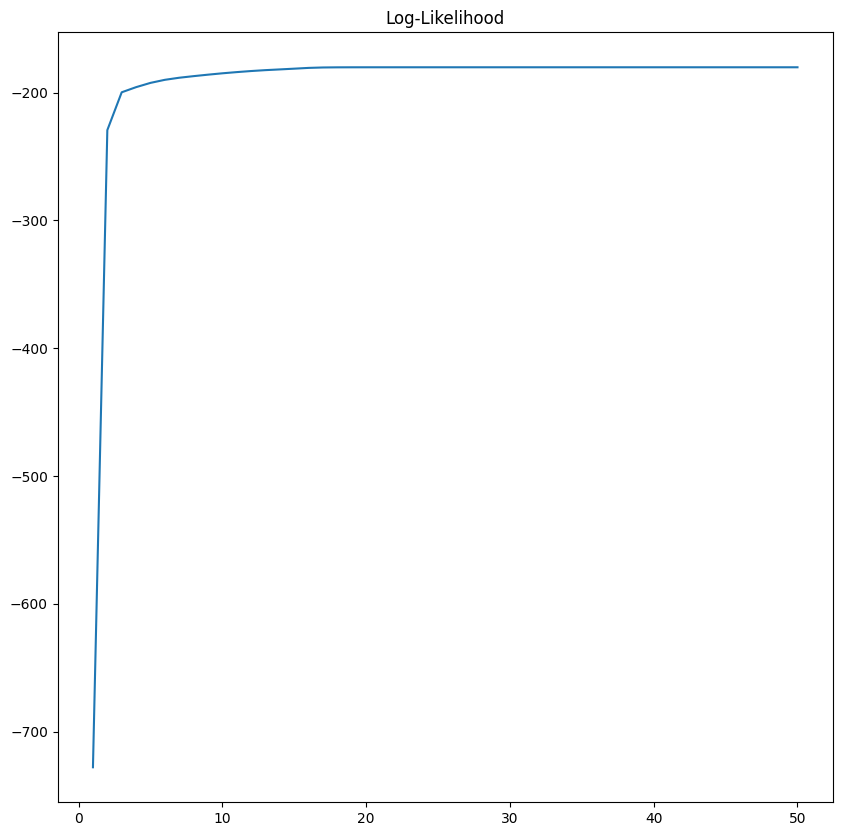

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs+1), likelihoods)
plt.show()

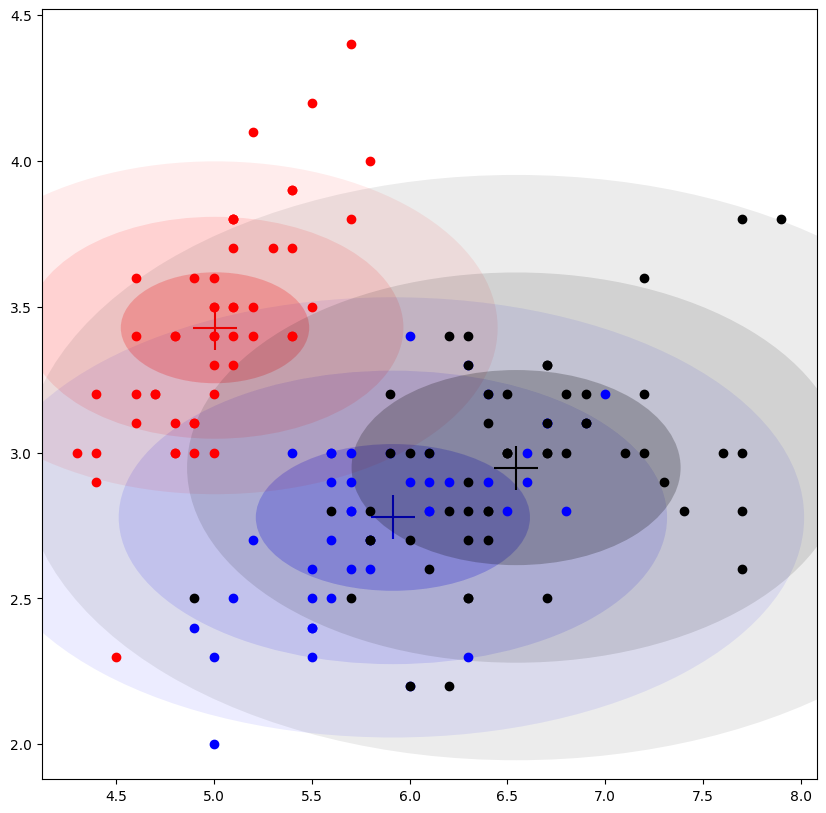

In [ ]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    colorset = ['blue', 'red', 'black']
    images = []

    for j, clusters in enumerate(history):

        idx = 0

        if j%3!=0:
          continue

        plt.cla()

        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                 ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height = np.sqrt(eigenvalues[1]) * cov_factor * 2)
                 ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor*4.5)))
                 ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s= 1000, marker='+')
            idx+=1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')

        fig.canvas.draw()

        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)

    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif',images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))

create_cluster_animation(X, history, scores)

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by sklearn:\n', gmm_scores[0:20])
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

Means by sklearn:
 [[5.91697517 2.77803998 4.20523542 1.29841561]
 [5.006      3.428      1.462      0.246     ]
 [6.54632887 2.94943079 5.4834877  1.98716063]]
Means by our implementation:
 [[5.91496959 2.77784365 4.20155323 1.29696685]
 [5.006      3.428      1.462      0.246     ]
 [6.54454865 2.94866115 5.47955343 1.98460495]]
Scores by sklearn:
 [ 1.57050082  0.73787138  1.14436656  0.92913238  1.411028   -0.09451903
  0.05266884  1.62442195  0.27082378  0.16706624  0.83489877  0.77168582
  0.29597841 -1.79224582 -3.41557928 -2.10529279 -1.12995447  1.47503579
 -0.84612536  0.97699215]
Scores by our implementation:
 [ 1.57057947  0.73793642  1.14444614  0.92920539  1.41110417 -0.09448868
  0.05268031  1.62449505  0.27090462  0.16702226  0.83494742  0.77171947
  0.29597776 -1.79222469 -3.41562626 -2.1052825  -1.1300608   1.47509939
 -0.84608424  0.9770596 ]
